In [101]:
import torch
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from time import time
import sys
from tensorflow.keras import Input, Model
from keras.preprocessing import image
from sklearn.linear_model import LinearRegression
import time
import pickle

### Main code block for detecting object & predicting distance using webcam 

Do not run this until the sections 'Create label dataframe' & below have finished running!

In [132]:
class ObjectDetection:
    '''load_model() loads yolov5 model using our saved custom weights'''
    '''custom weights may be saved differently, kindly refer to result from command line for location reference'''
    '''load_dist_model() loads our saved regression model'''
    '''conf is object probability threshold'''
    '''iou is NMS threshold'''
    '''Since we only have 1 class, classes will be = 0'''
    '''We will use gpu if available'''
    def __init__(self):
        self.model = self.load_model()
        self.dist_model = self.load_dist_model()
        self.model.conf = 0.65
        self.model.iou = 0.5 
        self.model.classes = [0] 
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
    '''Start webcam'''
    def get_video_from_file(self):
        cap = cv2.VideoCapture(0)
        assert cap is not None
        return cap

    def load_model(self):
        model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5\\runs\\train\\yolov5\\sagirac_data_det5\\weights\\best.pt')
        return model
    
    def load_dist_model(self):
        with open('sagirac_dataset/models/dist_model.pkl', 'rb') as f:
            reg = pickle.load(f)
        return reg    
    
    '''Use yolov5 to predict bounding box for each frame'''
    '''Return labels & bounding box coordinates'''
    def score_frame(self, frame):
        self.model.to(self.device)
        results = self.model([frame])
        labels, cord = results.xyxyn[0][:, -1].cpu().numpy(), results.xyxyn[0][:, :-1].cpu().numpy()
        return labels, cord

    '''Plot bounding box'''
    '''Each row in cord represents bounding box coordinates for each detected object'''
    '''Loop through each object"s coordinates & draw a rectangle[the bounding box] using coordinates given'''
    '''Also draw class probability'''
    '''Finally, we find max dimension of bounding box & feed into regression model to obtain distance prediction'''
    '''Draw distance prediction on frame'''
    '''Return frame'''
    def plot_boxes(self, results, frame):
        labels, cord = results
        n = len(labels)
        x_shape, y_shape = frame.shape[1], frame.shape[0]
        for i in range(n):
            row = cord[i]
            #upperleft_x,upperleft_y,lowerright_x,lowerright_y
            x1, y1, x2, y2 = int(row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 1)
            label = f"target: {round(row[4]*100,1)}%"
            cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            box_width, box_height = row[2]-row[0], row[3]-row[1]
            distance = round(self.dist_model.predict((np.array([max(box_width,box_height)]).reshape(-1, 1)))[0][0],1)
            cv2.putText(frame, f"distance: {distance}", (x1, y1-30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        return frame

    '''Main function to put everything together'''
    '''Start Camera > Start video recording(fourcc,out)[optional] > Get frame >  Calculate object scores & draw bounding boxes > Calculate object distances & draw distances > Print frame'''
    '''To quit, press Q'''
    def __call__(self):
        player = self.get_video_from_file() 
        assert player.isOpened()
        x_shape = int(player.get(cv2.CAP_PROP_FRAME_WIDTH))
        y_shape = int(player.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (640,480))
        while True:
            ret, frame = player.read()
            results = self.score_frame(frame)
            frame = self.plot_boxes(results, frame)
            cv2.imshow('frame',frame)
            out.write(frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        player.release()
        out.release()
        cv2.destroyAllWindows()


Starts the process. \
A window should open up if done correctly. 

In [133]:
ObjectDetection().__call__()

Using cache found in C:\Users\resce/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2021-11-11 torch 1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3080, 10239MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


### Create label dataframe 

Here, we create 2 CSVs[train & val] for distance prediction. \
First, we create a 'label' file using information from image annotation text files with the columns[filename,box_width,box_height]. \
Next, we create a 'df' file using images names found in augmneted images folder with the columns[filename,distance]. \
Finally, we merge both files on filename column so that each row shows an image name with its corersponding box width, box height & distance label. \
We shall also create a 'max dim' column which is the max of 'box_width' & 'box_height' .

In [75]:
path = 'sagirac_dataset/images/train'
label_path = 'sagirac_dataset/labels/train'
train_label = pd.DataFrame(columns=['filename','box_width','box_height'])
for i in range(len(os.listdir(path)[1:])):
    label = pd.read_csv(os.path.join(label_path,os.listdir(path)[1:][i][:-4]+'txt'), sep=" ", header=None)
    box_width, box_height = label[3][0], label[4][0]
    filename = os.listdir(path)[1:][i]
    train_label.loc[i] = [filename, box_width, box_height]

In [66]:
path = 'sagirac_dataset/images/val'
label_path = 'sagirac_dataset/labels/val'
val_label = pd.DataFrame(columns=['filename','box_width','box_height'])
for i in range(len(os.listdir(path)[1:])):
    label = pd.read_csv(os.path.join(label_path,os.listdir(path)[1:][i][:-4]+'.txt'), sep=" ", header=None)
    box_width, box_height = label[3][0], label[4][0]
    filename = os.listdir(path)[1:][i]
    val_label.loc[i] = [filename, box_width, box_height]

In [76]:
train_label

,filename,box_width,box_height
0,13_0_2444.jpeg,0.812500,0.652958
1,13_0_2741.jpeg,0.836851,0.696248
2,13_0_3167.jpeg,0.711851,0.678932
3,13_0_5575.jpeg,0.733766,0.645743
4,13_0_6109.jpeg,0.784091,0.653680
...,...,...,...
995,95_0_6360.jpeg,0.116883,0.207792
996,95_0_6548.jpeg,0.116883,0.210678
997,95_0_7970.jpeg,0.116883,0.206349
998,95_0_8155.jpeg,0.119318,0.206349


### Create CSV files for distance training  

In [48]:
train_df = pd.DataFrame(columns=['filename'],data=os.listdir('sagirac_dataset/distance_images/train'))
train_df['distance'] = train_df['filename'].map(lambda x:int(x.split('_')[0]))

In [77]:
train_merged = train_label.merge(train_df,on='filename')
train_merged.to_csv('train_distance_dimensions.csv',index=False)

In [64]:
val_df = pd.DataFrame(columns=['filename'],data=os.listdir('sagirac_dataset/distance_images/val'))
val_df['distance'] = val_df['filename'].map(lambda x:int(x.split('_')[2][:-4]))

In [68]:
val_merged = val_label.merge(val_df,on='filename')
val_merged.to_csv('val_distance_dimensions.csv',index=False)

In [78]:
train_merged['max dim'] = train_merged[['box_width','box_height']].values.max(1)
val_merged['max dim'] = val_merged[['box_width','box_height']].values.max(1)

In [137]:
train_merged

,filename,box_width,box_height,distance,max dim
0,13_0_2444.jpeg,0.812500,0.652958,13,0.812500
1,13_0_2741.jpeg,0.836851,0.696248,13,0.836851
2,13_0_3167.jpeg,0.711851,0.678932,13,0.711851
3,13_0_5575.jpeg,0.733766,0.645743,13,0.733766
4,13_0_6109.jpeg,0.784091,0.653680,13,0.784091
...,...,...,...,...,...
995,95_0_6360.jpeg,0.116883,0.207792,95,0.207792
996,95_0_6548.jpeg,0.116883,0.210678,95,0.210678
997,95_0_7970.jpeg,0.116883,0.206349,95,0.206349
998,95_0_8155.jpeg,0.119318,0.206349,95,0.206349


Let's see if a linear correlation exists between image max dim & distance. \
One can clearly see a nice[although not exactly linear] relationship between both variables. \
Extreme distances seem to be noisier. \
Nonetheless, let's stick using a linear regression model for predicting image distances for now.

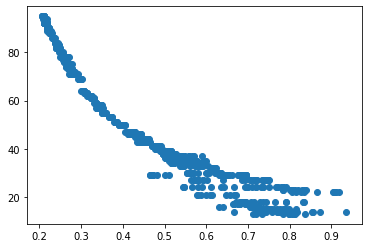

In [85]:
plt.scatter(train_merged['max dim'], train_merged['distance'])

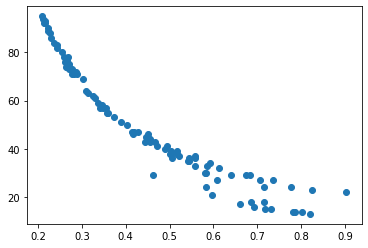

In [86]:
plt.scatter(val_merged['max dim'], val_merged['distance'])

### Modeling

Let's train our model on training images & labels. \
Save our trained model to dist_model.pkl.

In [92]:
reg = LinearRegression().fit(train_merged['max dim'].values.reshape(-1, 1), train_merged['distance'].values.reshape(-1, 1))
reg.score(train_merged['max dim'].values.reshape(-1, 1), train_merged['distance'].values.reshape(-1, 1))

0.8952691564096954

In [121]:
reg.predict(np.array(0.5).reshape(-1, 1))[0][0]

44.20288378780465

In [100]:
with open('sagirac_dataset/models/dist_model.pkl', 'wb') as f:
    pickle.dump(reg, f)

Now that both our object detection model & distance prediction model have been trained & saved, we can proceed to running the ObjectDetection class & observe our models in action